# ALS Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lenskit.algorithms.item_knn import ItemItem
from lenskit.metrics import topn as lm
import fastparquet
%matplotlib inline

In [15]:
dataset = 'ml-1m'

## Explicit Parameter Sweep

In [3]:
runs = pd.read_parquet(f'build/sweep-als-{dataset}-runs.parquet')
runs.head()

FileNotFoundError: [Errno 2] No such file or directory: 'build/sweep-als-ml-100k-runs.parquet'

### Training Time

In [4]:
train_time = runs.groupby(['features', 'regularization']).TrainTime.agg(['mean', 'min', 'max'])
train_time.head()

mean        min        max
features regularization                                 
5        0.01            14.521292  14.095455  15.826921
         0.05            14.183951  14.018807  14.348060
         0.10            14.189823  14.087938  14.281993
10       0.01            15.085923  14.972972  15.200739
         0.05            15.071787  14.961558  15.227893

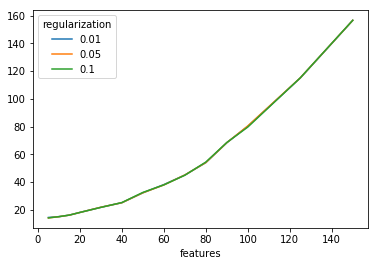

In [5]:
train_time.reset_index().pivot(index='features', columns='regularization', values='mean').plot()

Regularization does not affect training time, but feature count definitely does (as expected).

### Prediction Accuracy

In [4]:
preds = pd.read_parquet(f'build/sweep-als-{dataset}.parquet')
preds.head()

,index,user,item,rating,timestamp,prediction,features,regularization
0,321,7,3703,5.0,1049820598,3.887248,5,0.01
1,247,7,593,3.0,1049764435,4.423460,5,0.01
2,291,7,1590,3.0,1050098747,3.044372,5,0.01
3,345,7,5500,3.5,1055038214,3.630372,5,0.01
4,350,7,6273,4.0,1055038104,4.488814,5,0.01


In [5]:
preds['error'] = preds.rating - preds.prediction
preds['sqerr'] = preds.error * preds.error
mse = preds.groupby(['features', 'regularization']).sqerr.mean()
rmse = np.sqrt(mse)
rmse = rmse.reset_index(name='RMSE')
rmse.head()

,features,regularization,RMSE
0,5,0.01,0.875147
1,5,0.05,0.857125
2,5,0.10,0.861759
3,10,0.01,0.894736
4,10,0.05,0.848320


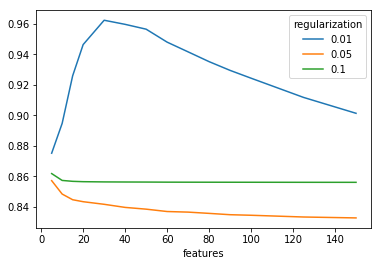

In [6]:
rmse_piv = rmse.pivot(index='features', columns='regularization', values='RMSE')
rmse_piv.plot()

## Implicit Parameter Sweep

In [4]:
runs = pd.read_parquet(f'build/sweep-als-both-{dataset}-runs.parquet')
runs.head()

,AlgoStr,Algorithm,Partition,PredictTime,RecTime,RunId,TrainTime,features
0,<lenskit.algorithms.basic.Popular object at 0x...,Popular,0,0.000135,0.448696,0,0.002857,NaN
1,<lenskit.algorithms.basic.Bias object at 0x7ff...,Bias,0,0.229546,0.560530,0,0.036193,NaN
2,"als.BiasedMF(features=5, regularization=0.1)",BiasedMF,0,0.311589,0.625077,1,2.298868,5.0
3,"als.BiasedMF(features=10, regularization=0.1)",BiasedMF,0,0.237952,0.633933,2,0.390408,10.0
4,"als.BiasedMF(features=15, regularization=0.1)",BiasedMF,0,0.238145,0.647065,3,0.399670,15.0


In [5]:
meta = runs.loc[:, ['RunId', 'Algorithm', 'features']]
meta.head()

,RunId,Algorithm,features
0,0,Popular,NaN
1,0,Bias,NaN
2,1,BiasedMF,5.0
3,2,BiasedMF,10.0
4,3,BiasedMF,15.0


### Training Time

In [6]:
train_time = runs.groupby(['Algorithm', 'features']).TrainTime.agg(['mean', 'min', 'max'])
train_time.head()

mean       min       max
Algorithm features                              
BiasedMF  5.0       0.754200  0.364814  2.298868
          10.0      0.413888  0.371257  0.473092
          15.0      0.393408  0.371251  0.427790
          20.0      0.399117  0.378565  0.428581
          30.0      0.495757  0.414873  0.582487

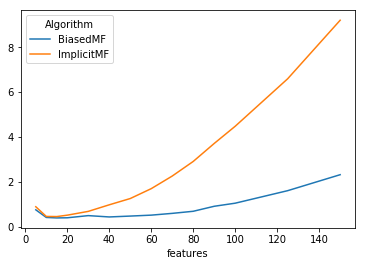

In [7]:
train_time.reset_index().pivot(index='features', columns='Algorithm', values='mean').plot()

### Top-N Accuracy

In [8]:
recs = pd.read_parquet(f'build/sweep-als-both-{dataset}-recs.parquet')
recs.head()

,user,rank,item,score,rating,timestamp,RunId
index,,,,,,,
0,2,1,181,501.0,0.0,NaN,0
1,2,2,121,426.0,0.0,NaN,0
2,2,3,300,424.0,4.0,888979197.0,0
3,2,4,174,417.0,0.0,NaN,0
4,2,5,56,390.0,0.0,NaN,0


In [9]:
recs.sort_values(['RunId', 'user', 'rank'], inplace=True)

In [10]:
user_ndcg = recs.groupby(['RunId', 'user']).rating.apply(lm.ndcg).reset_index(name='NDCG')
user_ndcg = pd.merge(meta, user_ndcg)
user_ndcg.head()

,RunId,Algorithm,features,user,NDCG
0,0,Popular,NaN,2,0.303038
1,0,Popular,NaN,5,0.265883
2,0,Popular,NaN,8,0.198806
3,0,Popular,NaN,14,0.206197
4,0,Popular,NaN,15,0.314612


In [11]:
base_ndcg = user_ndcg[user_ndcg.features.isna()].groupby('Algorithm').NDCG.mean().reset_index()
base_ndcg.head()

,Algorithm,NDCG
0,Bias,0.301668
1,Popular,0.301668


In [12]:
ndcg = user_ndcg.groupby(['Algorithm', 'features']).NDCG.mean().reset_index()
ndcg.head()

,Algorithm,features,NDCG
0,BiasedMF,5.0,0.138721
1,BiasedMF,10.0,0.146586
2,BiasedMF,15.0,0.148983
3,BiasedMF,20.0,0.152493
4,BiasedMF,30.0,0.159294


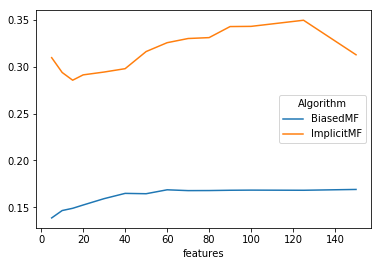

In [16]:
ndcg.pivot(index='features', columns='Algorithm', values='NDCG').plot()

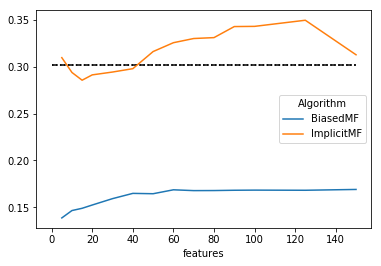

In [13]:
fig, ax = plt.subplots()
ndcg.pivot(index='features', columns='Algorithm', values='NDCG').plot(ax=ax)
plt.hlines(base_ndcg.NDCG, xmin=0, xmax=150,
           linestyles=['dashed', 'dotted'], label='Baseline')
plt.show()

## MF Comparison

In [16]:
runs = pd.read_parquet(f'build/sweep-mf-all-{dataset}-runs.parquet')
runs.head()

,AlgoStr,Algorithm,Partition,PredictTime,RecTime,RunId,TrainTime,features
0,<lenskit.algorithms.basic.Bias object at 0x7ff...,Bias,0,1.352481,3.735673,1,0.216346,NaN
1,<lenskit.algorithms.basic.Popular object at 0x...,Popular,0,0.000185,2.631747,2,0.016702,NaN
2,"als.BiasedMF(features=5, regularization=0.1)",BiasedMF,0,1.181867,4.190173,3,3.440725,5.0
3,"als.BiasedMF(features=10, regularization=0.1)",BiasedMF,0,1.166874,4.533411,4,1.572963,10.0
4,"als.BiasedMF(features=15, regularization=0.1)",BiasedMF,0,1.224158,4.948843,5,1.583276,15.0


In [17]:
meta = runs.loc[:, ['RunId', 'Algorithm', 'features']]
meta.head()

,RunId,Algorithm,features
0,1,Bias,NaN
1,2,Popular,NaN
2,3,BiasedMF,5.0
3,4,BiasedMF,10.0
4,5,BiasedMF,15.0


### Training Time

In [18]:
train_time = runs.groupby(['Algorithm', 'features']).TrainTime.agg(['mean', 'min', 'max'])
train_time.head()

mean       min       max
Algorithm features                              
BiasedMF  5.0       1.874119  1.452688  3.440725
          10.0      1.533499  1.476799  1.585749
          15.0      1.522917  1.489575  1.583276
          20.0      1.589171  1.555800  1.637212
          30.0      1.751716  1.712046  1.817823

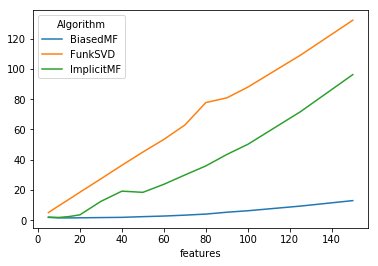

In [19]:
train_time.reset_index().pivot(index='features', columns='Algorithm', values='mean').plot()

### Predictive Accuracy

In [29]:
preds = pd.read_parquet(f'build/sweep-mf-all-{dataset}-preds.parquet')
preds.head()

,user,item,rating,timestamp,prediction,RunId
index,,,,,,
192,3,1079,5.0,978298296,4.048294,1
194,3,1615,5.0,978297710,3.694393,1
202,3,2858,4.0,978297039,4.396191,1
188,3,2735,4.0,978297867,2.980097,1
224,3,2617,2.0,978297837,3.403698,1


In [30]:
preds['error'] = preds.rating - preds.prediction
preds['sqerr'] = preds.error.apply(np.square)
run_rmse = preds.groupby('RunId').sqerr.mean().apply(np.sqrt).reset_index(name='RMSE')
run_rmse = pd.merge(meta, run_rmse)
run_rmse.head()

,RunId,Algorithm,features,RMSE
0,1,Bias,NaN,0.930708
1,3,BiasedMF,5.0,0.893400
2,4,BiasedMF,10.0,0.889167
3,5,BiasedMF,15.0,0.888089
4,6,BiasedMF,20.0,0.887593


In [32]:
base_rmse = run_rmse[run_rmse.features.isna()].groupby('Algorithm').RMSE.mean()
base_rmse

Algorithm
Bias    0.932682
Name: RMSE, dtype: float64

In [35]:
cfg_rmse = run_rmse.groupby(['Algorithm', 'features']).RMSE.mean().reset_index()
cfg_rmse = cfg_rmse[cfg_rmse.Algorithm != 'ImplicitMF']
cfg_rmse.head()

,Algorithm,features,RMSE
0,BiasedMF,5.0,0.898533
1,BiasedMF,10.0,0.893843
2,BiasedMF,15.0,0.893032
3,BiasedMF,20.0,0.891605
4,BiasedMF,30.0,0.891446


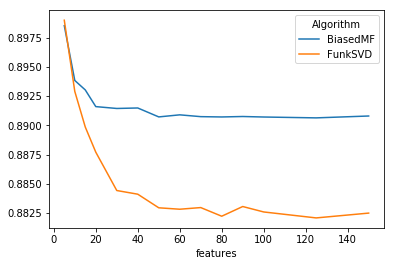

In [36]:
cfg_rmse.pivot(index='features', columns='Algorithm', values='RMSE').plot()

### Top-N Accuracy

In [21]:
recs = pd.read_parquet(f'build/sweep-mf-all-{dataset}-recs.parquet')
recs.head()

,user,rank,item,score,rating,timestamp,RunId
index,,,,,,,
0,3,1,2019,4.632651,0.0,NaN,1
1,3,2,318,4.630632,0.0,NaN,1
2,3,3,2905,4.619336,0.0,NaN,1
3,3,4,858,4.602297,0.0,NaN,1
4,3,5,50,4.599035,0.0,NaN,1


In [22]:
recs.sort_values(['RunId', 'user', 'rank'], inplace=True)

In [23]:
user_ndcg = recs.groupby(['RunId', 'user']).rating.apply(lm.ndcg).reset_index(name='NDCG')
user_ndcg = pd.merge(meta, user_ndcg)
user_ndcg.head()

,RunId,Algorithm,features,user,NDCG
0,1,Bias,NaN,3,0.186652
1,1,Bias,NaN,15,0.000000
2,1,Bias,NaN,16,0.000000
3,1,Bias,NaN,21,0.000000
4,1,Bias,NaN,22,0.000000


In [24]:
base_ndcg = user_ndcg[user_ndcg.features.isna()].groupby('Algorithm').NDCG.mean().reset_index()
base_ndcg.head()

,Algorithm,NDCG
0,Bias,0.126774
1,Popular,0.249421


In [25]:
ndcg = user_ndcg.groupby(['Algorithm', 'features']).NDCG.mean().reset_index()
ndcg.head()

,Algorithm,features,NDCG
0,BiasedMF,5.0,0.116455
1,BiasedMF,10.0,0.122476
2,BiasedMF,15.0,0.125453
3,BiasedMF,20.0,0.126677
4,BiasedMF,30.0,0.128429


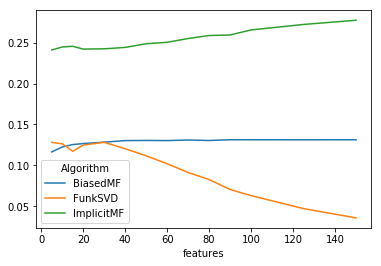

In [26]:
ndcg.pivot(index='features', columns='Algorithm', values='NDCG').plot()

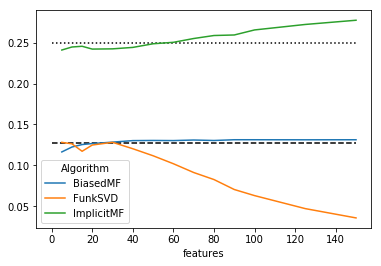

In [27]:
fig, ax = plt.subplots()
ndcg.pivot(index='features', columns='Algorithm', values='NDCG').plot(ax=ax)
plt.hlines(base_ndcg.NDCG, xmin=0, xmax=150,
           linestyles=['dashed', 'dotted'], label='Baseline')
plt.show()

## Training Study

In [ ]:
epochs = pd.read_csv('build/probe-als-ml-10m.csv')

In [ ]:
epochs.plot.scatter(x='epoch', y='rmse')